# Arbol de Calibracion - Tree

Notebook para calcular y visualizar constantes de calibracion de RTDs usando la clase `Tree`.

## Flujo
1. Cargar datos (Logfile + config.yml)
2. Procesar Sets
3. Construir arbol de calibracion
4. Calcular offsets globales
5. Visualizar resultados

In [15]:
import sys
import os
from pathlib import Path

# Agregar src al path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root / "RTD_Calibration" / "src"))

print(f"Project root: {project_root}")

from logfile import Logfile
from set import Set
from tree import Tree
import pandas as pd
import yaml

Project root: /Users/vicky/Desktop/rtd-calib-simple


## 1. Cargar datos

In [16]:
# Cargar Logfile
logfile_path = project_root / "RTD_Calibration" / "data" / "LogFile.csv"
logfile = Logfile(str(logfile_path))
print(f"Logfile cargado: {len(logfile.log_file)} registros")

# Cargar configuracion
config_path = project_root / "RTD_Calibration" / "config" / "config.yml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print(f"Configuracion cargada: {len(config['sensors']['sets'])} sets configurados")

CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/LogFile.csv'.
Logfile cargado: 832 registros
Configuracion cargada: 59 sets configurados


## 2. Procesar Sets

La clase `Set` agrupa runs por CalibSetNumber y calcula constantes de calibracion promediando los offsets de todos los runs de cada set.

In [17]:
# Crear handler de Sets
set_handler = Set()

# Obtener lista de sets desde config y asegurar que incluye R2 (49-56) y R3 (57)
set_ids_from_config = list(config['sensors']['sets'].keys())
print(f"Sets en config: {sorted([int(s) for s in set_ids_from_config])}")

# Asegurar que tenemos todos los sets críticos para el árbol de calibración
# R1: sets 3-48, R2: sets 49-56, R3: set 57
critical_sets = [49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0]
set_ids = list(set(set_ids_from_config) | set(critical_sets))
set_ids = sorted([s for s in set_ids if s in set_ids_from_config])  # Solo procesar los que existen

print(f"Procesando {len(set_ids)} sets (incluyendo R2 y R3)...")
print(f"Sets R2 (49-56): {[int(s) for s in set_ids if 49 <= s <= 56]}")
print(f"Set R3 (57): {57.0 in set_ids}")

# Agrupar runs y calcular constantes
set_handler.group_runs(set_ids)
set_handler.calculate_calibration_constants(set_ids)

# Crear diccionario para Tree
sets_dict = {}
for set_id in set_ids:
    if set_id in set_handler.calibration_constants:
        # Crear objeto simple con la estructura que Tree espera
        class SetData:
            def __init__(self, constants, errors):
                self.calibration_constants = constants
                self.calibration_errors = errors
                
        sets_dict[float(set_id)] = SetData(
            set_handler.calibration_constants[set_id],
            set_handler.calibration_errors[set_id]
        )

print(f"\nTotal sets procesados: {len(sets_dict)}")
print(f"Sets en sets_dict: {sorted([int(s) for s in sets_dict.keys()])}")

# Verificar sets críticos
print(f"\n✓ Verificación de sets R2 y R3:")
for s in [49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0]:
    if s in sets_dict:
        print(f"  Set {int(s)}: ✓ Cargado")
    else:
        print(f"  Set {int(s)}: ✗ NO cargado")

# Mostrar resumen
summary = set_handler.get_summary()
print("\nResumen por Set:")
print(summary.head(10))

CSV file loaded successfully from '/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/LogFile.csv'.
Sets en config: [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63]
Procesando 59 sets (incluyendo R2 y R3)...
Sets R2 (49-56): [49, 50, 51, 52, 53, 54, 55]
Set R3 (57): True

=== Agrupando runs por CalibSetNumber ===
Sets a procesar: [np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0), np.float64(25.0), np.float64(26.0), np.float64(27.0), np.float64(28.0), np.float64(29.0), np.float64(30.0),

/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. P

  Datos cargados: 2042 registros
  Sensores asociados: 14
  Incluido: 20220701_ln2_r48421_r48177_48840-48851_2
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_8/20220701_ln2_r48421_r48177_48840-48851_3.txt
  Datos cargados: 883 registros
  Sensores asociados: 14
  Incluido: 20220701_ln2_r48421_r48177_48840-48851_3
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_8/20220701_ln2_r48421_r48177_48840-48851_4.txt
  Datos cargados: 5231 registros
  Sensores asociados: 14
  Incluido: 20220701_ln2_r48421_r48177_48840-48851_4
  Excluido (keywords): 20220701_ln2_r48421_r48177_48840-48851_1_pre
  Excluido (keywords): 20220701_ln2_r48421_r48177_48840-48851_2_pre
  Excluido (keywords): 20220701_ln2_r48421_r48177_48840-48851_3_pre
  Excluido (keywords): 20220701_ln2_r48421_r48177_48840-48851_4_pre
  Total runs válidos: 4

Procesando Set 9.0
Cargando: /Users/vicky/Desktop/rtd-calib-simpl

/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(
/Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/src/run.py:123: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. P

  Datos cargados: 7233 registros
  Sensores asociados: 14
  Incluido: 20240628_ln2_r49215_r48422_48900-48911_4
  Excluido (keywords): 20240628_ln2_r49215_r48422_48900-48911_1_pre
  Excluido (keywords): 20240628_ln2_r49215_r48422_48900-48911_2_pre
  Excluido (keywords): 20240628_ln2_r49215_r48422_48900-48911_3_pre
  Excluido (keywords): 20240628_ln2_r49215_r48422_48900-48911_4_pre
  Total runs válidos: 4

Procesando Set 14.0
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_14/20240627_ln2_r49215_r48422_48912-48963_1.txt
  Datos cargados: 865 registros
  Sensores asociados: 14
  Incluido: 20240627_ln2_r49215_r48422_48912-48963_1
Cargando: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/temperature_files/RTD_Calibs/CalSetN_14/20240627_ln2_r49215_r48422_48912-48963_2.txt
  Datos cargados: 680 registros
  Sensores asociados: 14
  Incluido: 20240627_ln2_r49215_r48422_48912-48963_2
Cargando: /Users/vicky/Desktop/rtd-calib-sim

## 2.5 Debug: Ejemplo matemático del cálculo de constantes

Veamos paso a paso cómo se calcula una constante de calibración para un sensor de R1 usando el método de media ponderada.

In [4]:
import numpy as np
import pandas as pd

# Ejemplo: Calcular constante para sensor 48060 del Set 3 (R1)
# Este sensor debe conectarse al Set 57 (R3 - referencia)

print("="*80)
print("EJEMPLO: Cálculo de constante de calibración para sensor 48060 (Set 3, Ronda 1)")
print("="*80)

# Paso 1: Identificar el sensor y su set
sensor_r1 = '48060'
set_r1 = 3
set_r3 = 57  # Set de referencia

print(f"\n📍 SENSOR OBJETIVO: {sensor_r1} (Set {set_r1}, Ronda 1)")
print(f"🎯 REFERENCIA: Set {set_r3} (Ronda 3)")

# Verificar que el Set 57 esté cargado
if float(set_r3) not in sets_dict:
    print(f"\n⚠️  ADVERTENCIA: Set {set_r3} no está cargado en sets_dict")
    print(f"Sets disponibles: {sorted([int(s) for s in sets_dict.keys()])}")
    print("\nPara procesar este ejemplo, necesitas cargar el Set 57 primero.")
    print("Ejecuta la celda anterior con set_ids que incluya el 57.")
else:
    print(f"✓ Set {set_r3} está cargado correctamente")
    
    # Diagnóstico del Set 57
    set_r3_obj = sets_dict[float(set_r3)]
    constants_r3 = set_r3_obj.calibration_constants
    print(f"\n🔍 DIAGNÓSTICO SET 57:")
    print(f"   Sensores en index (filas): {list(constants_r3.index)}")
    print(f"   Sensores en columns: {list(constants_r3.columns)}")
    print(f"   Dimensiones: {constants_r3.shape}")
    
    # Determinar el sensor de referencia absoluta (misma lógica que Tree)
    set_r3_config = config['sensors']['sets'][set_r3]
    ref_sensors = set_r3_config.get('sensors', [])
    reference_sensors_config = set_r3_config.get('reference', [])
    raised_sensors_config = set_r3_config.get('raised', [])
    discarded_sensors_config = set_r3_config.get('discarded', [])
    
    # Elegir el primer sensor que NO sea reference, raised ni discarded
    excluded = set(reference_sensors_config + raised_sensors_config + discarded_sensors_config)
    
    reference_sensor_absolute = None
    for sensor in ref_sensors:
        if sensor not in excluded:
            reference_sensor_absolute = sensor
            break
    
    if reference_sensor_absolute is None:
        reference_sensor_absolute = ref_sensors[0]
    
    print(f"\n🎯 SENSOR DE REFERENCIA ABSOLUTA (elegido por Tree): {reference_sensor_absolute}")
    print(f"   (Primer sensor que no es reference/raised/discarded)")

# Paso 2: Obtener sensores raised del Set 3
set_3_config = config['sensors']['sets'][set_r1]
raised_r1 = set_3_config.get('raised', [])

print(f"\n🔗 SENSORES RAISED en Set {set_r1}: {raised_r1}")
print(f"   Estos sensores conectan la Ronda 1 con la Ronda 2")

# Paso 3: Para cada raised sensor, obtener el offset dentro del Set 3
set_3 = sets_dict[float(set_r1)]
constants_r1 = set_3.calibration_constants  # Matriz NxN de offsets

print(f"\n📊 OFFSETS DENTRO DEL SET {set_r1} (del sensor {sensor_r1} a cada raised):")
print("-" * 80)

offsets_to_raised = {}
errors_to_raised = {}

for raised in raised_r1:
    raised_str = str(raised)
    if raised_str in constants_r1.index and sensor_r1 in constants_r1.columns:
        offset = constants_r1.loc[raised_str, sensor_r1]
        error = set_3.calibration_errors.loc[raised_str, sensor_r1]
        
        if not pd.isna(offset):
            offsets_to_raised[raised] = offset
            errors_to_raised[raised] = error
            print(f"  {sensor_r1} → {raised}: {offset:.6f} K  (error: {error:.6f} K)")
        else:
            print(f"  {sensor_r1} → {raised}: No disponible (NaN)")
    else:
        print(f"  {sensor_r1} → {raised}: No encontrado en matriz")

# Paso 4: Para cada raised R1, encontrar en qué Set R2 está
print(f"\n🔗 BÚSQUEDA DE RAISED R1 EN RONDA 2:")
print("-" * 80)

paths = []  # Lista de (raised_r1, set_r2, raised_r2, offset_total, error_total)

for raised_r1_sensor in offsets_to_raised.keys():
    # Buscar en qué sets de R2 aparece este sensor raised
    for set_num, set_config in config['sensors']['sets'].items():
        if set_num == set_r1:  # Saltar el set de origen
            continue
        
        # Verificar si este raised_r1 está en el set R2
        if raised_r1_sensor in set_config.get('sensors', []) or \
           raised_r1_sensor in set_config.get('raised', []):
            
            # Este es un set R2 que contiene nuestro raised_r1
            # Ahora buscar los raised de este set R2
            raised_r2_list = set_config.get('raised', [])
            
            if float(set_num) in sets_dict and len(raised_r2_list) > 0:
                set_r2 = sets_dict[float(set_num)]
                constants_r2 = set_r2.calibration_constants
                
                print(f"\n  ✓ {raised_r1_sensor} encontrado en Set {set_num} (R2)")
                print(f"    Raised R2 en este set: {raised_r2_list}")
                
                # Para cada raised R2, calcular el camino completo
                for raised_r2_sensor in raised_r2_list:
                    raised_r2_str = str(raised_r2_sensor)
                    raised_r1_str = str(raised_r1_sensor)
                    
                    if raised_r2_str in constants_r2.index and \
                       raised_r1_str in constants_r2.columns:
                        
                        offset_r2 = constants_r2.loc[raised_r2_str, raised_r1_str]
                        error_r2 = set_r2.calibration_errors.loc[raised_r2_str, raised_r1_str]
                        
                        if not pd.isna(offset_r2):
                            # Offset acumulado hasta ahora
                            offset_r1 = offsets_to_raised[raised_r1_sensor]
                            error_r1 = errors_to_raised[raised_r1_sensor]
                            
                            offset_r1_to_r2 = offset_r1 + offset_r2
                            error_r1_to_r2 = np.sqrt(error_r1**2 + error_r2**2)
                            
                            print(f"      {raised_r1_sensor} → {raised_r2_sensor}: {offset_r2:.6f} K (error: {error_r2:.6f} K)")
                            print(f"      Offset acumulado R1→R2: {offset_r1_to_r2:.6f} K (error propagado: {error_r1_to_r2:.6f} K)")
                            
                            # Ahora buscar este raised_r2 en el Set 57 (R3)
                            if float(set_r3) in sets_dict:
                                set_r3_obj = sets_dict[float(set_r3)]
                                constants_r3 = set_r3_obj.calibration_constants
                                
                                print(f"      Buscando {raised_r2_sensor} → {reference_sensor_absolute} en Set {set_r3}...")
                                
                                # Verificar si el raised_r2 está en la matriz
                                if raised_r2_str in constants_r3.index:
                                    ref_sensor_str = str(reference_sensor_absolute)
                                    
                                    if ref_sensor_str in constants_r3.columns:
                                        offset_r3 = constants_r3.loc[raised_r2_str, ref_sensor_str]
                                        error_r3 = set_r3_obj.calibration_errors.loc[raised_r2_str, ref_sensor_str]
                                        
                                        if not pd.isna(offset_r3):
                                            # Offset total
                                            offset_total = offset_r1_to_r2 + offset_r3
                                            error_total = np.sqrt(error_r1_to_r2**2 + error_r3**2)
                                            
                                            print(f"        ✅ {raised_r2_sensor} → {reference_sensor_absolute}: {offset_r3:.6f} K (error: {error_r3:.6f} K)")
                                            print(f"        ✅ OFFSET TOTAL: {offset_total:.6f} K (error total: {error_total:.6f} K)")
                                            
                                            paths.append({
                                                'raised_r1': raised_r1_sensor,
                                                'set_r2': set_num,
                                                'raised_r2': raised_r2_sensor,
                                                'reference': reference_sensor_absolute,
                                                'offset_r1': offset_r1,
                                                'error_r1': error_r1,
                                                'offset_r2': offset_r2,
                                                'error_r2': error_r2,
                                                'offset_r3': offset_r3,
                                                'error_r3': error_r3,
                                                'offset_total': offset_total,
                                                'error_total': error_total
                                            })
                                        else:
                                            print(f"        ❌ {raised_r2_sensor} → {reference_sensor_absolute}: NaN")
                                    else:
                                        print(f"        ⚠️  {reference_sensor_absolute} no está en columns")
                                else:
                                    print(f"        ⚠️  {raised_r2_sensor} no está en index")
                            else:
                                print(f"      ⚠️  Set {set_r3} no está en sets_dict")

# Paso 5: Calcular media ponderada
print(f"\n" + "="*80)
print(f"RESUMEN: {len(paths)} CAMINOS ENCONTRADOS")
print("="*80)

if len(paths) > 0:
    paths_df = pd.DataFrame(paths)
    
    print("\nTabla de caminos:")
    print(paths_df[['raised_r1', 'set_r2', 'raised_r2', 'reference', 'offset_total', 'error_total']].to_string(index=False))
    
    print(f"\n🧮 CÁLCULO DE MEDIA PONDERADA (por error²):")
    print("-" * 80)
    
    weights = 1 / (paths_df['error_total'] ** 2)
    weighted_sum = (paths_df['offset_total'] * weights).sum()
    weight_sum = weights.sum()
    
    final_offset = weighted_sum / weight_sum
    final_error = np.sqrt(1 / weight_sum)
    
    print("\nPesos (1/error²):")
    for i, row in paths_df.iterrows():
        w = 1 / (row['error_total'] ** 2)
        print(f"  Camino {i+1}: peso = 1/{row['error_total']:.6f}² = {w:.2f}")
    
    print(f"\nΣ(offset × peso) = {weighted_sum:.6f}")
    print(f"Σ(peso) = {weight_sum:.2f}")
    
    print(f"\n{'='*80}")
    print(f"🎯 CONSTANTE FINAL para sensor {sensor_r1}:")
    print(f"   Offset = {final_offset:.6f} K")
    print(f"   Error = {final_error:.6f} K")
    print(f"{'='*80}")
    
    # Mostrar la fórmula matemática
    print(f"\n📐 FÓRMULA MATEMÁTICA:")
    print("-" * 80)
    print(f"   offset_final = Σ(offset_i × w_i) / Σ(w_i)")
    print(f"   donde w_i = 1 / error_i²")
    print(f"   error_final = √(1 / Σ(w_i))")
    
else:
    print("\n⚠️  No se encontraron caminos válidos para este sensor")
    print(f"\n💡 El sensor de referencia absoluta es: {reference_sensor_absolute}")
    print(f"   Verifica que los sensores raised de R2 tengan offsets hacia este sensor en Set 57")

print(f"\n{'='*80}")

EJEMPLO: Cálculo de constante de calibración para sensor 48060 (Set 3, Ronda 1)

📍 SENSOR OBJETIVO: 48060 (Set 3, Ronda 1)
🎯 REFERENCIA: Set 57 (Ronda 3)
✓ Set 57 está cargado correctamente

🔍 DIAGNÓSTICO SET 57:
   Sensores en index (filas): ['48484', '48747', '48869', '48956', '49112', '49167', '55233', '55073', '55253', '55227', '49233', '55221', '48177', '48421']
   Sensores en columns: ['48484', '48747', '48869', '48956', '49112', '49167', '55233', '55073', '55253', '55227', '49233', '55221', '48177', '48421']
   Dimensiones: (14, 14)

🎯 SENSOR DE REFERENCIA ABSOLUTA (elegido por Tree): 48484
   (Primer sensor que no es reference/raised/discarded)

🔗 SENSORES RAISED en Set 3: [48203, 48479]
   Estos sensores conectan la Ronda 1 con la Ronda 2

📊 OFFSETS DENTRO DEL SET 3 (del sensor 48060 a cada raised):
--------------------------------------------------------------------------------
  48060 → 48203: -0.073624 K  (error: 0.000624 K)
  48060 → 48479: -0.066355 K  (error: 0.000463 K)

## 3. Construir arbol de calibracion

Crear el arbol que conecta sets de diferentes rondas usando sensores raised.

In [5]:
tree = Tree(sets_dict, str(config_path))
tree.print_tree_structure()


Sets clasificados por ronda:
  Ronda 1: 47 sets -> [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 59.0, 60.0]
  Ronda 2: 7 sets -> [49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0]
  Ronda 3: 1 sets -> [57.0]

ESTRUCTURA DEL ARBOL DE CALIBRACION

RONDA 3 (1 sets)
----------------------------------------------------------------------
  Set 57: 12 sensores

RONDA 2 (7 sets)
----------------------------------------------------------------------
  Set 49: 12 sensores | 2 raised: [48484, 48747]
  Set 50: 12 sensores | 2 raised: [48869, 48956]
  Set 51: 12 sensores | 2 raised: [49112, 49167]
  Set 52: 12 sensores | 2 raised: [49233, 55073]
  Set 53: 12 sensores | 2 raised: [55253, 55227]
  Set 54: 12 sensores | 2 raised: [55233, 55221]
  Set 55: 12 sensores | 6 raised: [54869, 54870, 

## 4. Calcular offsets globales

Calcular offsets de sensores de R1 respecto a la referencia absoluta en R3 (Set 57).

El algoritmo encadena offsets:
- **Paso 1**: Sensor → Raised (dentro del mismo set R1)
- **Paso 2**: Raised_R1 → Raised_R2 (en set R2 correspondiente)
- **Paso 3**: Raised_R2 → Referencia (en Set 57, R3)

El error se propaga como raíz de la suma de cuadrados.

In [6]:
# Recargar módulo tree para aplicar cambios
import importlib
import sys
tree_module = sys.modules.get('tree')
if tree_module:
    importlib.reload(tree_module)
    from tree import Tree
    tree = Tree(sets_dict, str(config_path))
    print("Módulo tree recargado\n")

# Calcular offsets para sets R1 (3-39) relacionados con Set 57 (R3)
# Estos sets tienen conexión completa a través de sets R2 (49-54)
# Sets 40-48 no están incluidos en este rango (procesarán con otra referencia)
print("=== CALCULANDO SETS R1 (3-39) → R3 (57) ===\n")
global_constants = tree.calculate_all_offsets(r1_sets_range=(3, 39))
print(f"\nConstantes globales calculadas: {len(global_constants)} filas")


Sets clasificados por ronda:
  Ronda 1: 47 sets -> [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 59.0, 60.0]
  Ronda 2: 7 sets -> [49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0]
  Ronda 3: 1 sets -> [57.0]
Módulo tree recargado

=== CALCULANDO SETS R1 (3-39) → R3 (57) ===


Calculando offsets respecto a Set 57.0 (Ronda 3)
  Modo manual: Limitando a sets R1 del 3 al 39
  Referencia absoluta: Sensor 48484
  Procesando 36 sets de Ronda 1

=== RESULTADOS ===:
  Total sensores: 433
  Calculados: 376
  Descartados: 0
  Sin conexión: 0
  Error promedio: 0.2803 K
  Error máximo: 62.7639 K

Estadísticas de offsets:
  Promedio: 0.2559 K
  Desv. Std: 0.6351 K
  Min: -0.3026 K
  Max: 11.5482 K
Total sensores R1 procesados: 432

Constantes globales calculadas: 433 filas


In [7]:
# Análisis de resultados
print("\n=== Análisis de resultados ===")
print(f"Total filas en CSV: {len(global_constants)}")
print(f"\nDistribución por Status:")
print(global_constants['Status'].value_counts())

# Estadísticas de sensores calculados
calculated = global_constants[global_constants['Status'] == 'Calculado']
if len(calculated) > 0:
    print(f"\n=== Sensores Calculados ===")
    print(f"Total: {len(calculated)}")
    print(f"Constante promedio: {calculated['Constante_Calibracion_K'].mean():.4f} K")
    print(f"Constante std: {calculated['Constante_Calibracion_K'].std():.4f} K")
    print(f"Error promedio: {calculated['Error_K'].mean():.5f} K")

# Mostrar sensores descartados por set
discarded = global_constants[global_constants['Status'] == 'Sensor descartado']
if len(discarded) > 0:
    print(f"\n=== Sensores Descartados ===")
    print(f"Total: {len(discarded)}")
    print(f"Por set:")
    print(discarded.groupby('Set').size().sort_index())


=== Análisis de resultados ===
Total filas en CSV: 433

Distribución por Status:
Status
Calculado            376
Sensor descartado     56
Referencia             1
Name: count, dtype: int64

=== Sensores Calculados ===
Total: 376
Constante promedio: 0.2559 K
Constante std: 0.6351 K
Error promedio: 0.28029 K

=== Sensores Descartados ===
Total: 56
Por set:
Set
3.0     2
4.0     2
5.0     1
6.0     2
7.0     3
8.0     2
14.0    3
15.0    2
16.0    2
17.0    2
18.0    1
19.0    1
21.0    2
22.0    2
23.0    4
24.0    1
25.0    2
26.0    3
27.0    3
28.0    2
29.0    1
30.0    3
31.0    1
32.0    1
33.0    1
35.0    3
36.0    1
37.0    2
38.0    1
dtype: int64


## 5. Visualizar resultados

### 5.1 Resumen por Set

In [8]:
# Resumen por set
import numpy as np

summary = global_constants.groupby('Set').agg({
    'Constante_Calibracion_K': [('mean', lambda x: np.nanmean(x)), 
                                 ('std', lambda x: np.nanstd(x)), 
                                 'count'],
    'Error_K': [('mean', lambda x: np.nanmean(x))],
    'Status': [('Calculado', lambda x: (x == 'Calculado').sum()),
               ('Descartado', lambda x: (x == 'Sensor descartado').sum()),
               ('Sin_conexion', lambda x: (x == 'Sin conexión').sum()),
               ('Referencia', lambda x: (x == 'Referencia').sum())]
}).round(4)

summary.columns = ['Constante_media', 'Std_constante', 'N_sensores', 'Error_medio', 
                   'Calculados', 'Descartados', 'Sin_conexion', 'Referencia']

# Ordenar por número de set
summary = summary.sort_index()

print("\nResumen por Set:")
print(summary)


Resumen por Set:
      Constante_media  Std_constante  N_sensores  Error_medio  Calculados  \
Set                                                                         
3.0           -0.0639         0.0305          10       0.0011          10   
4.0           -0.0192         0.0384          10       0.0007          10   
5.0           -0.0372         0.0280          11       0.0008          11   
6.0           -0.0162         0.0669          10       0.0016          10   
7.0           -0.0256         0.0306           9       0.0010           9   
8.0           -0.0340         0.0316          10       0.0015          10   
9.0            0.0816         0.0704          12       0.1532          12   
10.0           0.1941         0.2461          12       0.0030          12   
11.0           0.1449         0.2159          12       0.2996          12   
13.0           0.0876         0.2149          12       0.3253          12   
14.0           0.1915         0.2416           9       0.0

### 5.2 Constantes de sensores especificos

Ver detalles de algunos sensores.

In [9]:
# Ver primeros 10 sensores calculados
calculated = global_constants[global_constants['Status'] == 'Calculado']
print("\nPrimeros 10 sensores calculados:")
print(calculated[['Sensor', 'Set', 'Constante_Calibracion_K', 'Error_K']].head(10))


Primeros 10 sensores calculados:
    Sensor  Set  Constante_Calibracion_K   Error_K
0    48060  3.0                -0.009736  0.001096
1    48061  3.0                -0.043393  0.000968
2    48062  3.0                -0.033115  0.001094
3    48063  3.0                -0.043830  0.001185
4    48202  3.0                -0.110627  0.001317
5    48203  3.0                -0.083360  0.001024
6    48204  3.0                -0.051313  0.001092
8    48476  3.0                -0.093760  0.001198
9    48477  3.0                -0.093319  0.001099
11   48479  3.0                -0.076159  0.000964


### 5.3 Distribucion de offsets

Visualizar la distribucion de los offsets calculados.

### 5.4 Guardar resultados

In [10]:
# Guardar a CSV
output_path = project_root / "RTD_Calibration" / "data" / "results" / "calibration_constants_notebook.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

global_constants.to_csv(output_path, index=False)
print(f"\nResultados guardados en: {output_path}")


Resultados guardados en: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/results/calibration_constants_notebook.csv


### 5.5 Generar CSV con pasos detallados (opcional)

Este CSV adicional contiene los 3 pasos intermedios del cálculo encadenado para cada sensor.

In [11]:
# Generar CSVs con pasos detallados
print("Generando CSVs con información detallada de pasos intermedios...\n")

df_main, df_steps = tree.calculate_all_offsets_with_steps(r1_sets_range=(3, 39))

# Guardar CSV principal (actualizado con nombre de columna correcto)
output_main = project_root / "RTD_Calibration" / "data" / "results" / "calibration_constants_notebook.csv"
df_main.to_csv(output_main, index=False)
print(f"\nCSV principal guardado: {output_main}")

# Guardar CSV con pasos
output_steps = project_root / "RTD_Calibration" / "data" / "results" / "calibration_pasos_intermedios.csv"
df_steps.to_csv(output_steps, index=False)
print(f"CSV pasos intermedios guardado: {output_steps}")

print(f"\n✓ CSV principal: {len(df_main)} filas")
print(f"✓ CSV pasos: {len(df_steps)} filas (solo sensores calculados)")

# Mostrar ejemplo de pasos
if len(df_steps) > 0:
    print("\n=== Ejemplo de pasos intermedios (primer sensor) ===")
    print(df_steps.iloc[0].to_string())

Generando CSVs con información detallada de pasos intermedios...


Calculando offsets CON PASOS DETALLADOS respecto a Set 57.0
  Modo manual: Limitando a sets R1 del 3 al 39
  Procesando 36 sets de Ronda 1
  Referencia absoluta: Sensor 48484

=== RESULTADOS ===:
  Total sensores: 433
  Calculados: 376
  Descartados: 0
  Sin conexión: 0
  Error promedio: 0.2803 K
  Error máximo: 62.7639 K
CSV principal: 433 filas
CSV pasos: 376 filas

CSV principal guardado: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/results/calibration_constants_notebook.csv
CSV pasos intermedios guardado: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/results/calibration_pasos_intermedios.csv

✓ CSV principal: 433 filas
✓ CSV pasos: 376 filas (solo sensores calculados)

=== Ejemplo de pasos intermedios (primer sensor) ===
Sensor                     48060.000000
Set                            3.000000
Round                          1.000000
Constante_Calibracion_K       -0.009736
Error_Total

### 5.6 Análisis Multi-Camino (Exploración de alternativas)

Este análisis explora **todos** los caminos posibles para cada sensor y compara:
- **Primer camino válido** (estrategia actual)
- **Camino de error mínimo**
- **Media ponderada** de todos los caminos (ponderada por 1/error²)

Permite detectar sensores con alta variabilidad entre caminos.

In [18]:
# Análisis explorando TODOS los caminos posibles
print("Realizando análisis multi-camino...")
print("(Esto puede tardar un poco más porque explora todas las combinaciones)\n")

df_multi = tree.calculate_all_offsets_multi_path(r1_sets_range=(3, 39))

# Guardar CSV de análisis
output_multi = project_root / "RTD_Calibration" / "data" / "results" / "calibration_analisis_multicamino.csv"
df_multi.to_csv(output_multi, index=False)
print(f"\n✓ CSV análisis multi-camino guardado: {output_multi}")
print(f"  Total filas: {len(df_multi)}")

# Mostrar ejemplo con sensor que tenga múltiples caminos
multi_path_sensors = df_multi[df_multi['N_Caminos'] > 1]
if len(multi_path_sensors) > 0:
    print(f"\n=== Ejemplo: Sensor con múltiples caminos ===")
    ejemplo = multi_path_sensors.iloc[0]
    print(f"Sensor {int(ejemplo['Sensor'])} (Set {int(ejemplo['Set'])})")
    print(f"  Número de caminos válidos: {int(ejemplo['N_Caminos'])}")
    print(f"  Primer camino:      {ejemplo['Constante_Primer_Camino_K']:.6f} ± {ejemplo['Error_Primer_Camino_K']:.6f} K")
    print(f"  Min error:          {ejemplo['Constante_Min_Error_K']:.6f} ± {ejemplo['Error_Min_K']:.6f} K")
    print(f"  Media ponderada:    {ejemplo['Constante_Media_Ponderada_K']:.6f} ± {ejemplo['Error_Media_Ponderada_K']:.6f} K")
    print(f"  Std entre caminos:  {ejemplo['Std_Entre_Caminos_K']:.6f} K")
    print(f"  Max diferencia:     {ejemplo['Max_Diff_Caminos_K']:.6f} K")

Realizando análisis multi-camino...
(Esto puede tardar un poco más porque explora todas las combinaciones)


=== ANÁLISIS MULTI-CAMINO ===
Explorando TODOS los caminos posibles para cada sensor

  Modo manual: Limitando a sets R1 del 3 al 39
Referencia absoluta: Sensor 48484 (Set 57.0)
Procesando 36 sets de Ronda 1


=== RESULTADOS MULTI-CAMINO ===:
  Total sensores: 432
  Calculados: 376
  Descartados: 0
  Sin conexión: 0
Caminos promedio por sensor: 4.0
Sensores con múltiples caminos: 376

=== Diferencias entre estrategias ===
Primer camino vs Min Error:
  Diferencia promedio: 0.089085 K
  Diferencia máxima: 0.331132 K

Primer camino vs Media Ponderada:
  Diferencia promedio: 0.081272 K
  Diferencia máxima: 0.304793 K

=== Variabilidad entre caminos ===
Std promedio entre caminos: 0.053427 K
Max diferencia promedio: 0.120684 K

⚠ 252 sensores con alta variabilidad (std > 0.01 K)

✓ CSV análisis multi-camino guardado: /Users/vicky/Desktop/rtd-calib-simple/RTD_Calibration/data/results/

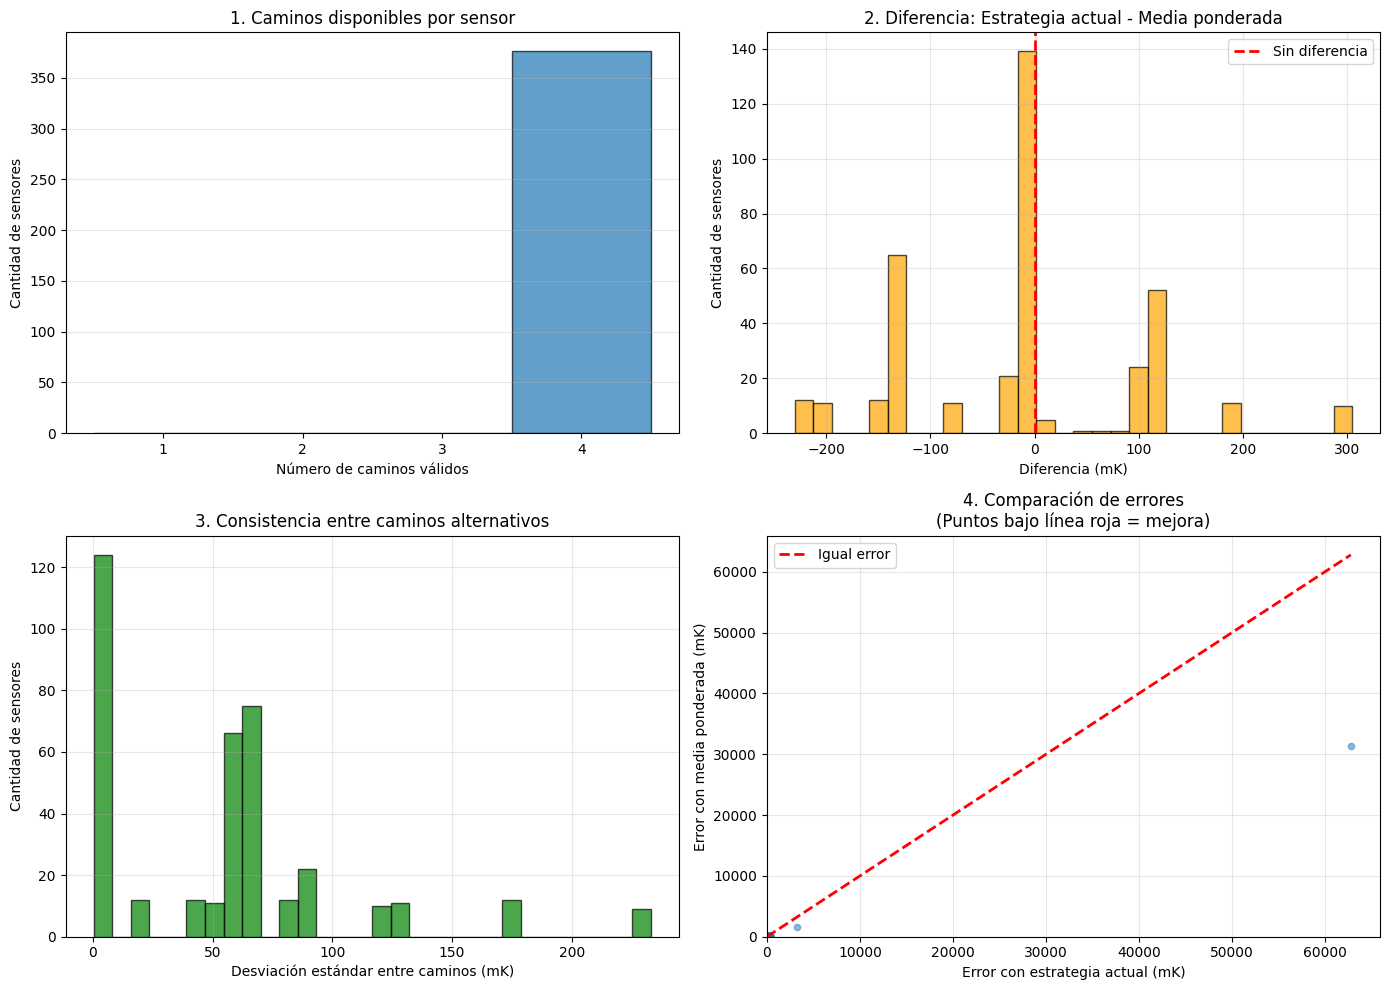


=== Resumen ===
La media ponderada reduce el error en: 376/376 sensores
Reducción promedio: 179.926 mK


In [13]:
# Visualización de resultados multi-camino
import matplotlib.pyplot as plt

calculated_multi = df_multi[df_multi['Status'] == 'Calculado']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de caminos por sensor
n_caminos_vals = calculated_multi['N_Caminos'].values
axes[0, 0].hist(n_caminos_vals, bins=[0.5, 1.5, 2.5, 3.5, 4.5], edgecolor='black', alpha=0.7, align='mid')
axes[0, 0].set_xticks([1, 2, 3, 4])
axes[0, 0].set_xlabel('Número de caminos válidos')
axes[0, 0].set_ylabel('Cantidad de sensores')
axes[0, 0].set_title('1. Caminos disponibles por sensor')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Diferencia entre estrategias
diff_media = calculated_multi['Constante_Primer_Camino_K'] - calculated_multi['Constante_Media_Ponderada_K']
axes[0, 1].hist(diff_media * 1000, bins=30, edgecolor='black', color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Diferencia (mK)')
axes[0, 1].set_ylabel('Cantidad de sensores')
axes[0, 1].set_title('2. Diferencia: Estrategia actual - Media ponderada')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Sin diferencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Consistencia entre caminos
axes[1, 0].hist(calculated_multi['Std_Entre_Caminos_K'] * 1000, bins=30, edgecolor='black', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Desviación estándar entre caminos (mK)')
axes[1, 0].set_ylabel('Cantidad de sensores')
axes[1, 0].set_title('3. Consistencia entre caminos alternativos')
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparación de errores (ajustar rango para ver datos)
error_actual = calculated_multi['Error_Primer_Camino_K'] * 1000
error_ponderado = calculated_multi['Error_Media_Ponderada_K'] * 1000

# Determinar rango dinámico
max_val = max(error_actual.max(), error_ponderado.max())
axes[1, 1].scatter(error_actual, error_ponderado, alpha=0.5, s=20)
axes[1, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Igual error')
axes[1, 1].set_xlabel('Error con estrategia actual (mK)')
axes[1, 1].set_ylabel('Error con media ponderada (mK)')
axes[1, 1].set_title('4. Comparación de errores\n(Puntos bajo línea roja = mejora)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, max_val * 1.05])
axes[1, 1].set_ylim([0, max_val * 1.05])

plt.tight_layout()
plt.show()

# Resumen
mejora_error = (calculated_multi['Error_Media_Ponderada_K'] < calculated_multi['Error_Primer_Camino_K']).sum()
print(f"\n=== Resumen ===")
print(f"La media ponderada reduce el error en: {mejora_error}/{len(calculated_multi)} sensores")
print(f"Reducción promedio: {(calculated_multi['Error_Primer_Camino_K'] - calculated_multi['Error_Media_Ponderada_K']).mean() * 1000:.3f} mK")

### 5.7 Comparación visual de las 3 estrategias

Distribución de constantes y errores para cada método de cálculo.

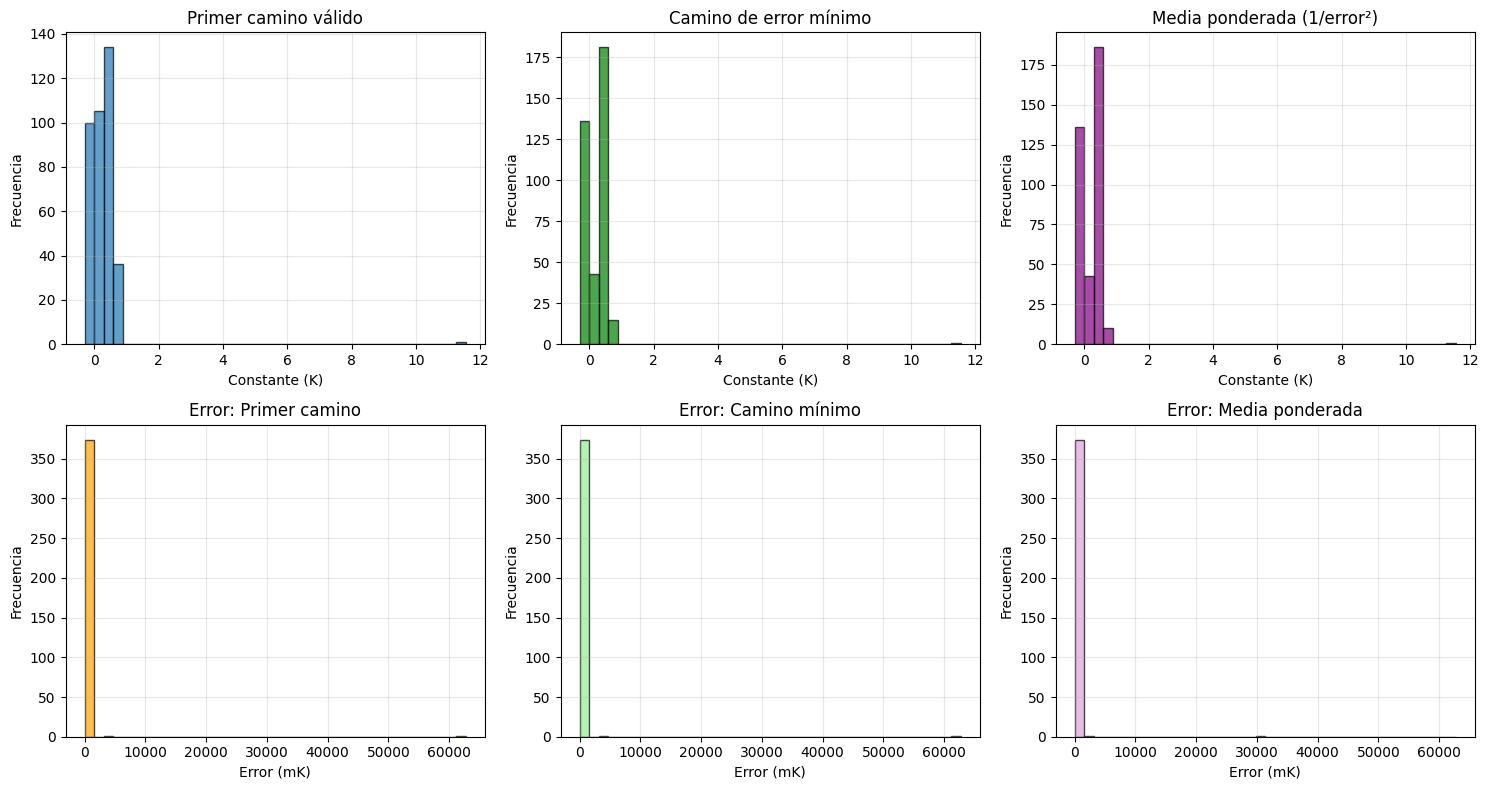


=== Comparación de estrategias ===

1. PRIMER CAMINO VÁLIDO (estrategia en calibration_constants_notebook.csv):
   Error medio: 280.286 mK
   Error std: 3236.596 mK

2. CAMINO DE ERROR MÍNIMO:
   Error medio: 193.061 mK
   Error std: 3240.055 mK
   Mejora vs actual: 87.225 mK

3. MEDIA PONDERADA (recomendado):
   Error medio: 100.360 mK
   Error std: 1619.937 mK
   Mejora vs actual: 179.926 mK


In [14]:
# Comparación visual de las 3 estrategias
import matplotlib.pyplot as plt

calculated_multi = df_multi[df_multi['Status'] == 'Calculado']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Calcular rangos comunes para constantes (fila 1)
const_min = min(calculated_multi['Constante_Primer_Camino_K'].min(),
                calculated_multi['Constante_Min_Error_K'].min(),
                calculated_multi['Constante_Media_Ponderada_K'].min())
const_max = max(calculated_multi['Constante_Primer_Camino_K'].max(),
                calculated_multi['Constante_Min_Error_K'].max(),
                calculated_multi['Constante_Media_Ponderada_K'].max())
const_bins = 40

# Fila 1: Distribución de constantes de calibración (con mismo rango)
axes[0, 0].hist(calculated_multi['Constante_Primer_Camino_K'], bins=const_bins, 
                range=(const_min, const_max), edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Constante (K)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Primer camino válido')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(calculated_multi['Constante_Min_Error_K'], bins=const_bins,
                range=(const_min, const_max), edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Constante (K)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Camino de error mínimo')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(calculated_multi['Constante_Media_Ponderada_K'], bins=const_bins,
                range=(const_min, const_max), edgecolor='black', alpha=0.7, color='purple')
axes[0, 2].set_xlabel('Constante (K)')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].set_title('Media ponderada (1/error²)')
axes[0, 2].grid(True, alpha=0.3)

# Calcular rangos comunes para errores (fila 2, en mK)
error_min = min((calculated_multi['Error_Primer_Camino_K'] * 1000).min(),
                (calculated_multi['Error_Min_K'] * 1000).min(),
                (calculated_multi['Error_Media_Ponderada_K'] * 1000).min())
error_max = max((calculated_multi['Error_Primer_Camino_K'] * 1000).max(),
                (calculated_multi['Error_Min_K'] * 1000).max(),
                (calculated_multi['Error_Media_Ponderada_K'] * 1000).max())
error_bins = 40

# Fila 2: Distribución de errores (en mK, con mismo rango)
axes[1, 0].hist(calculated_multi['Error_Primer_Camino_K'] * 1000, bins=error_bins,
                range=(error_min, error_max), edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Error (mK)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Error: Primer camino')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(calculated_multi['Error_Min_K'] * 1000, bins=error_bins,
                range=(error_min, error_max), edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 1].set_xlabel('Error (mK)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Error: Camino mínimo')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(calculated_multi['Error_Media_Ponderada_K'] * 1000, bins=error_bins,
                range=(error_min, error_max), edgecolor='black', alpha=0.7, color='plum')
axes[1, 2].set_xlabel('Error (mK)')
axes[1, 2].set_ylabel('Frecuencia')
axes[1, 2].set_title('Error: Media ponderada')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print(f"\n=== Comparación de estrategias ===")
print(f"\n1. PRIMER CAMINO VÁLIDO (estrategia en calibration_constants_notebook.csv):")
print(f"   Error medio: {calculated_multi['Error_Primer_Camino_K'].mean() * 1000:.3f} mK")
print(f"   Error std: {calculated_multi['Error_Primer_Camino_K'].std() * 1000:.3f} mK")

print(f"\n2. CAMINO DE ERROR MÍNIMO:")
print(f"   Error medio: {calculated_multi['Error_Min_K'].mean() * 1000:.3f} mK")
print(f"   Error std: {calculated_multi['Error_Min_K'].std() * 1000:.3f} mK")
print(f"   Mejora vs actual: {(calculated_multi['Error_Primer_Camino_K'].mean() - calculated_multi['Error_Min_K'].mean()) * 1000:.3f} mK")

print(f"\n3. MEDIA PONDERADA (recomendado):")
print(f"   Error medio: {calculated_multi['Error_Media_Ponderada_K'].mean() * 1000:.3f} mK")
print(f"   Error std: {calculated_multi['Error_Media_Ponderada_K'].std() * 1000:.3f} mK")
print(f"   Mejora vs actual: {(calculated_multi['Error_Primer_Camino_K'].mean() - calculated_multi['Error_Media_Ponderada_K'].mean()) * 1000:.3f} mK")